# NLP Process - Text Classification

## 1. import libraries
## 2. dataset
## 3. EDA
## 4. Text data Processing
## 5. Transforming tokens to vectors
## 6. Text Classification models - with different classifiers

# IMPORTING

In [5]:
import pandas as pd
import numpy as np

# text processing libraries

import re
import string
import nltk
from nltk.corpus import stopwords

# sklearn

from sklearn import preprocessing, model_selection, decomposition, pipeline, metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import f1_score
import xgboost as xgb
from xgboost import XGBClassifier

# plotting

import matplotlib.pyplot as plt
import seaborn as sns

import os
import warnings
warnings.filterwarnings('ignore')

# dataset

In [6]:
traindf = pd.read_csv('train.csv')
traindf.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
print(f'Training data set size: {traindf.shape}')

Training data set size: (7613, 5)


In [9]:
testdf = pd.read_csv('test.csv')
testdf.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [10]:
print(f'Testing data set size: {testdf.shape}')

Testing data set size: (3263, 4)


# EDA

## Missing values

### since our focus is on 'text' column, the missing values in other columns are of no effect to us

In [12]:
traindf.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [13]:
testdf.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

## Exploring the column -  Target
### text is tweets about the disaster
### 1 for disaster, 0 for no disaster

In [16]:
traindf.target.unique()

array([1, 0], dtype=int64)

In [17]:
traindf['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

### this is almost balanced class

<AxesSubplot: ylabel='target'>

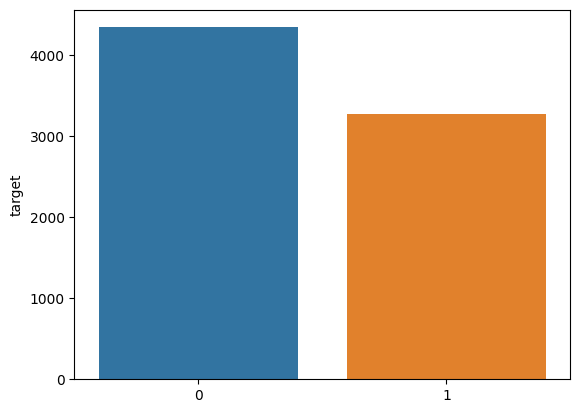

In [26]:
sns.barplot(x = traindf['target'].value_counts().index, y = traindf['target'].value_counts())

In [28]:
disaster_tweet = traindf[traindf['target'] == 1]['text']
non_disaster_tweet = traindf[traindf['target'] == 0]['text']

In [29]:
disaster_tweet.values[1]

'Forest fire near La Ronge Sask. Canada'

In [30]:
non_disaster_tweet.values[1]

'I love fruits'

## Exploring the column - Keyword

<AxesSubplot: xlabel='keyword'>

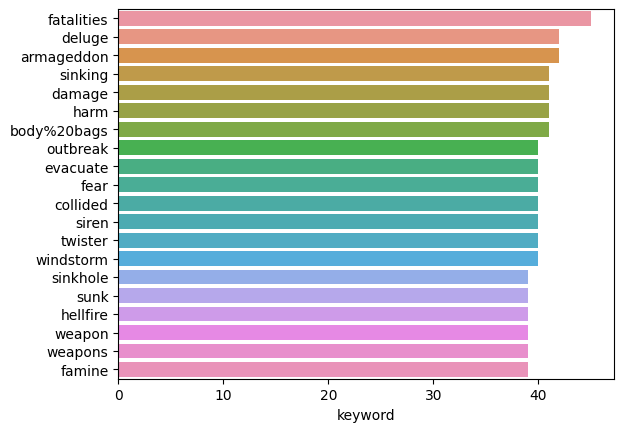

In [31]:
sns.barplot(y = traindf['keyword'].value_counts()[:20].index, x = traindf['keyword'].value_counts()[:20]) 

In [36]:
traindf['keyword'].value_counts()

fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

<AxesSubplot: xlabel='location'>

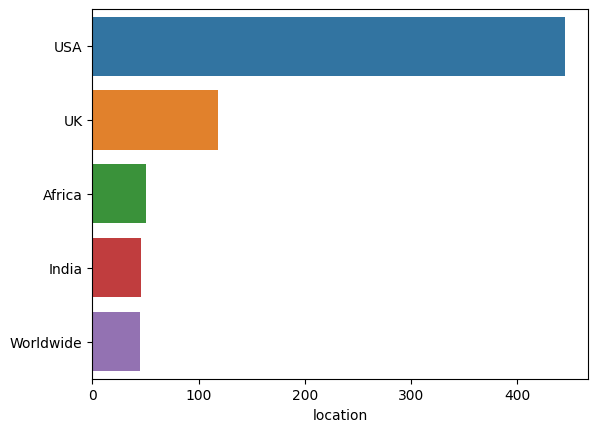

In [37]:
# Exploring the column- Location

traindf['location'].replace({'United States':'USA',
                           'New York':'USA',
                            "London":'UK',
                            "Los Angeles, CA":'USA',
                            "Washington, D.C.":'USA',
                            "California":'USA',
                             "Chicago, IL":'USA',
                             "Chicago":'USA',
                            "New York, NY":'USA',
                            "California, USA":'USA',
                            "FLorida":'USA',
                            "Nigeria":'Africa',
                            "Kenya":'Africa',
                            "Everywhere":'Worldwide',
                            "San Francisco":'USA',
                            "Florida":'USA',
                            "United Kingdom":'UK',
                            "Los Angeles":'USA',
                            "Toronto":'Canada',
                            "San Francisco, CA":'USA',
                            "NYC":'USA',
                            "Seattle":'USA',
                            "Earth":'Worldwide',
                            "Ireland":'UK',
                            "London, England":'UK',
                            "New York City":'USA',
                            "Texas":'USA',
                            "London, UK":'UK',
                            "Atlanta, GA":'USA',
                            "Mumbai":"India"},inplace=True)

sns.barplot(y = traindf['location'].value_counts()[:5].index, x = traindf['location'].value_counts()[:5])

## Text Preprocessing

In [39]:
traindf['text'][:5]

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object

In [38]:
# Data cleaning
# Lower case, Noise removal, Tokenising, Stopwords

In [40]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

traindf['text']=traindf['text'].apply(lambda x:clean_text(x))
testdf['text']=testdf['text'].apply(lambda x:clean_text(x))
traindf['text'][:5]

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3     people receive wildfires evacuation orders in...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

Text(0.5, 1.0, 'Non-Disaster Tweets')

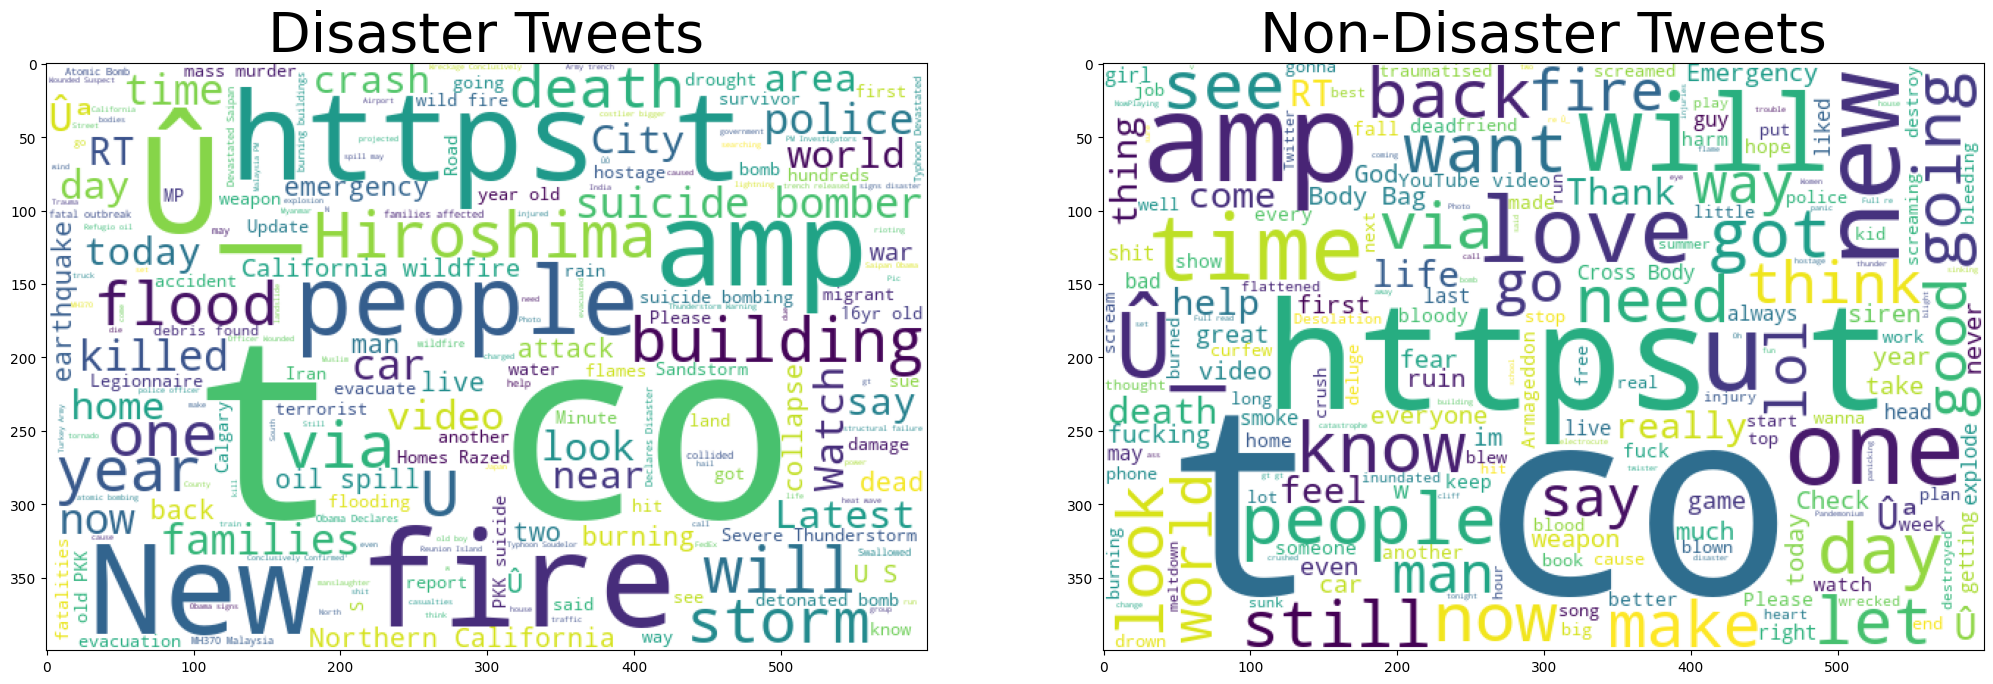

In [45]:
from wordcloud import WordCloud
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [25, 10])

# ax1 => disaster_tweet

wordcloud1 = WordCloud(background_color = 'white',
                      width = 600,
                      height = 400).generate(' '.join(disaster_tweet))

ax1.imshow(wordcloud1)
ax1.set_title('Disaster Tweets', fontsize = 40)



# ax2 => non_disaster_tweet

wordcloud2 = WordCloud(background_color = 'white',
                      width = 600,
                      height = 400).generate(' '.join(non_disaster_tweet))

ax2.imshow(wordcloud2)
ax2.set_title('Non-Disaster Tweets', fontsize = 40)

## Tokenization

In [47]:
tokens = nltk.tokenize.RegexpTokenizer(r'\w+')
traindf['text'] = traindf['text'].apply(lambda x: tokens.tokenize(x))
testdf['text'] = testdf['text'].apply(lambda x: tokens.tokenize(x))

In [48]:
traindf['text'].head()

0    [our, deeds, are, the, reason, of, this, earth...
1        [forest, fire, near, la, ronge, sask, canada]
2    [all, residents, asked, to, shelter, in, place...
3    [people, receive, wildfires, evacuation, order...
4    [just, got, sent, this, photo, from, ruby, ala...
Name: text, dtype: object

## Stopwords

In [49]:
def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words

traindf['text'] = traindf['text'].apply(lambda x: remove_stopwords(x))
testdf['text'] = testdf['text'].apply(lambda x: remove_stopwords(x))

In [50]:
traindf['text'].head()

0    [deeds, reason, earthquake, may, allah, forgiv...
1        [forest, fire, near, la, ronge, sask, canada]
2    [residents, asked, shelter, place, notified, o...
3    [people, receive, wildfires, evacuation, order...
4    [got, sent, photo, ruby, alaska, smoke, wildfi...
Name: text, dtype: object

## Normalization
### stemming, lemmatization

In [51]:
# since we are not doing 'info extraction', but we need to do 'text classification' we need not do this step here

In [52]:
def combine_text(list_text):
    combined_text = ' '.join(list_text)
    return combined_text

In [53]:
traindf['text'] = traindf['text'].apply(lambda x: combine_text(x))
testdf['text'] = testdf['text'].apply(lambda x: combine_text(x))

In [54]:
traindf['text'].head()

0         deeds reason earthquake may allah forgive us
1                forest fire near la ronge sask canada
2    residents asked shelter place notified officer...
3    people receive wildfires evacuation orders cal...
4    got sent photo ruby alaska smoke wildfires pou...
Name: text, dtype: object

In [56]:
# Getting all together

def text_preprocess(text):
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    clean_data = clean_text(text)
    tokenized_data = tokenizer.tokenize(clean_data)
    remove_stopwords = [w for w in tokenized_data if w not in stopwords.words('english')]
    combined_text = ' '.join(remove_stopwords)
    return combined_text

## Transforming tokens to vector

In [57]:
# Bag of words

In [60]:
# CountVector

count_vectorizer = CountVectorizer()
train_vector = count_vectorizer.fit_transform(traindf['text'])
test_vector = count_vectorizer.transform(testdf['text'])

print(train_vector[0].todense())

[[0 0 0 ... 0 0 0]]


In [63]:
# Tfidf

tfidf = TfidfVectorizer(min_df = 2, max_df = 0.5, ngram_range = (1,2))

train_tfidf = tfidf.fit_transform(traindf['text'])
test_tfidf = tfidf.transform(testdf['text'])


## Building text classification - Model

In [66]:
# Logistic Regression
# count vector 

clf = LogisticRegression(C = 1.0)     # decreasing C will increase the chances of overfitting
scores = model_selection.cross_val_score(clf, train_vector, traindf['target'], cv = 5, scoring = 'f1')
scores


array([0.59865255, 0.49611063, 0.57166948, 0.56290774, 0.68789809])

In [67]:
# Logistic regression
# tfidf

clf_tfidf = LogisticRegression(C = 1.0)     # decreasing C will increase the chances of overfitting
scores = model_selection.cross_val_score(clf, train_tfidf, traindf['target'], cv = 5, scoring = 'f1')
scores

array([0.57229525, 0.49673203, 0.54277829, 0.46618106, 0.64768683])

In [69]:
# Naives bayes
# Count vector

clf_nb = MultinomialNB()
scores = model_selection.cross_val_score(clf_nb, train_vector, traindf['target'], cv = 5, scoring = 'f1')
scores


array([0.63149079, 0.60675773, 0.68575519, 0.64341085, 0.72505092])

In [70]:
# Naivs bayes
# tfidf

clf_nb_tfidf = MultinomialNB()
scores = model_selection.cross_val_score(clf_nb_tfidf, train_tfidf, traindf['target'], cv = 5, scoring = 'f1')
scores

array([0.57590597, 0.57092511, 0.61135371, 0.5962963 , 0.7393745 ])

In [71]:
# xgboost
# Count vector

clf_xgb = xgb.XGBClassifier(max_depth = 7, n_estimators = 200, colsample_bytree = 0.8, subsample = 0.8, nthread = 10, learning_rate = 0.1)
scores = model_selection.cross_val_score(clf_xgb, train_vector, traindf['target'], cv = 5, scoring = 'f1')
scores


array([0.4882227 , 0.378119  , 0.43348837, 0.39451477, 0.53154876])

In [72]:
# xgboost
# tfidf

clf_xgb_tfidf = xgb.XGBClassifier(max_depth = 7, n_estimators = 200, colsample_bytree = 0.8, subsample = 0.8, nthread = 10, learning_rate = 0.1)
scores = model_selection.cross_val_score(clf_xgb_tfidf, train_tfidf, traindf['target'], cv = 5, scoring = 'f1')
scores

array([0.49336283, 0.35483871, 0.42709313, 0.40384615, 0.52509653])